# CSE 6240 - Web Search & Text Mining - Project 2

# k-Sparse Encoder

In [2]:
# __author__ = 'Bhanu Verma', 'Nilaksh Das'
# GTid = '903151012', '903129996'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import math
from PIL import Image
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import tensorflow as tf
from matplotlib.pyplot import imshow
%matplotlib inline

In [15]:
categoryArr = []
animal_path = 'Data/Animal'
person_path = 'Data/Person'

# animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
categoryArr = [animal_path, person_path]

size_tuple = (16,16)
count = 0
enco_bat_size = 50
category_count_list = [0,0]

for i in range(len(categoryArr)):
    cat_dir = os.listdir(categoryArr[i])
    category_count_list[i] += len(cat_dir)
    
animal_data = np.zeros(shape=(category_count_list[0],size_tuple[0]*size_tuple[1]))
person_data = np.zeros(shape=(category_count_list[1],size_tuple[0]*size_tuple[1]))

In [16]:
def get_image_data(path):
    img = Image.open(path)
    resized_img = img.resize(size_tuple)
    img_arr = np.array(resized_img.convert('L')).flatten()
    arr = img_arr
    img.close()
    
    return arr            

In [17]:
def get_category_data(folder,data):
    img_count = 0
    category = os.listdir(folder)
    for img_file in category:
        path = folder + "/" + img_file
        data[img_count] = get_image_data(path)
        img_count += 1
        if img_count % 200 == 0:
            print('Number of images loaded from ', folder,": ",img_count)
    return data

In [18]:
animal_data = get_category_data(animal_path,animal_data)
person_data = get_category_data(person_path,person_data)

Number of images loaded from  Data/Animal :  200
Number of images loaded from  Data/Animal :  400
Number of images loaded from  Data/Animal :  600
Number of images loaded from  Data/Animal :  800
Number of images loaded from  Data/Animal :  1000
Number of images loaded from  Data/Animal :  1200
Number of images loaded from  Data/Animal :  1400
Number of images loaded from  Data/Person :  200
Number of images loaded from  Data/Person :  400
Number of images loaded from  Data/Person :  600
Number of images loaded from  Data/Person :  800
Number of images loaded from  Data/Person :  1000
Number of images loaded from  Data/Person :  1200


In [19]:
# Standard preprocessing of data
scale = preprocessing.StandardScaler().fit(animal_data)
scaled_animal_data = scale.transform(animal_data)

scale = preprocessing.StandardScaler().fit(person_data)
scaled_person_data = scale.transform(person_data)

In [20]:
# split data into training and testing data
training_animal_data,testing_animal_data = train_test_split(scaled_animal_data, train_size=0.8, random_state=42)
training_person_data,testing_person_data = train_test_split(scaled_person_data, train_size=0.8, random_state=42)

print(testing_animal_data.shape,training_animal_data.shape)
print(testing_person_data.shape,training_person_data.shape)

(315, 256) (1256, 256)
(249, 256) (993, 256)


In [22]:
def auto_encoder(training_data,number_iterations,learning_rate, errors, layers, sparsity_level, sparse=False):
    top_k_layers = [int(sparsity_level * a) for a in layers]
    sess = tf.Session()
    start = 0
    end = start + enco_bat_size
    original_data_dim = training_data.shape[1]
    with sess.as_default():
        hidden_dim = layers[0]
        input_dim = original_data_dim
        x = tf.placeholder("float", [None, input_dim])
        W1 = tf.Variable(tf.random_uniform([input_dim, hidden_dim], -1.0 / math.sqrt(input_dim),\
                                          1.0 / math.sqrt(input_dim)))
        b1 = tf.Variable(tf.zeros([hidden_dim]))
        z1 = tf.nn.tanh(tf.matmul(x,W1) + b1)
        
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[0])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[enco_bat_size,1])
            z_new = tf.sub(z1,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z1
        
        input_dim = hidden_dim
        hidden_dim = layers[1]
        W2 = tf.Variable(tf.random_uniform([input_dim, hidden_dim], -1.0 / math.sqrt(input_dim),\
                                          1.0 / math.sqrt(input_dim)))
        b2 = tf.Variable(tf.zeros([hidden_dim]))
        z2 = tf.nn.tanh(tf.matmul(z1,W2) + b2)
        
        if sparse:
            vals,indices = tf.nn.top_k(z2,top_k_layers[1])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[enco_bat_size,1])
            z_new = tf.sub(z2,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z2
        
        Wdash2 = tf.transpose(W2)
        bdash2 = tf.Variable(tf.zeros([layers[0]]))
        reconstructed_x1 = tf.nn.tanh(tf.matmul(z_new,Wdash2) + bdash2)
        
        
        Wdash1 = tf.transpose(W1)
        bdash1 = tf.Variable(tf.zeros([original_data_dim]))
        reconstructed_x = tf.nn.tanh(tf.matmul(reconstructed_x1,Wdash1) + bdash1)
        

        error = tf.reduce_mean(tf.square(x-reconstructed_x))
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)
        init = tf.initialize_all_variables()
        sess.run(init)

        for i in range(number_iterations): 
            batch_rows = np.random.choice(range(0,training_data.shape[0]), enco_bat_size, replace=False)
            batch = training_data[batch_rows][:]
            sess.run(train_step, feed_dict={x: batch})
            e = sess.run(error, feed_dict={x: batch})
            errors.append(e)
        print("Autoencoder training done")
        w1_final = sess.run(W1)
        b1_final = sess.run(b1)
        w2_final = sess.run(W2)
        b2_final = sess.run(b2)
        w1_dash_final = sess.run(Wdash1)
        b1_dash_final = sess.run(bdash1)
        w2_dash_final = sess.run(Wdash2)
        b2_dash_final = sess.run(bdash2)
        ws = [w1_final,w2_final]
        ws_dash = [w1_dash_final,w2_dash_final]
        bs = [b1_final, b2_final]
        bs_dash = [b1_dash_final,b2_dash_final]
    return ws,ws_dash,bs,bs_dash



In [23]:
def get_testing_error(testing_data,ws,bs,ws_dash,bs_dash,sparse=False):
    top_k_layers = [int(sparsity_level * a) for a in layers]
    errors = []
    sess2 = tf.Session()
    input_dim = testing_data.shape[1]
    with sess2.as_default():
        w1 = tf.Variable(ws[0],dtype=tf.float32)
        b1 = tf.Variable(bs[0],dtype=tf.float32)
        w2 = tf.Variable(ws[1],dtype=tf.float32)
        b2 = tf.Variable(bs[1],dtype=tf.float32)

        w1_dash = tf.Variable(ws_dash[0],dtype=tf.float32)
        b1_dash = tf.Variable(bs_dash[0],dtype=tf.float32)
        w2_dash = tf.Variable(ws_dash[1],dtype=tf.float32)
        b2_dash = tf.Variable(bs_dash[1],dtype=tf.float32)
        
        x = tf.placeholder("float", [None, input_dim])
        z1 = tf.nn.tanh(tf.matmul(x,w1) + b1) 
        
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[0])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[1,1])
            z_new = tf.sub(z1,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z1
            
        z2 = tf.nn.tanh(tf.matmul(z_new,w2) + b2) 
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[1])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[1,1])
            z_new = tf.sub(z2,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z2
            
        reconstructed_x1 = tf.nn.tanh(tf.matmul(z_new,w2_dash) + b2_dash)
        reconstructed_x = tf.nn.tanh(tf.matmul(reconstructed_x1,w1_dash) + b1_dash)
        error = tf.reduce_mean(tf.square(x-reconstructed_x))
        init = tf.initialize_all_variables()
        sess2.run(init)

        for i in range(len(testing_data)): 
            batch = testing_data[i][:].reshape((1,input_dim))
            e = sess2.run(error, feed_dict={x: batch})
            errors.append(e)
        print("Test error calculated")
        return np.mean(errors)

In [24]:
sparsity_levels = [0.9,0.8]
errors_sparsity = []
person_errors_sparse = []
layers = [50,40]
for sparsity_level in sparsity_levels:
    print(sparsity_level)
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_person_data,10000,0.03,errors,layers,sparsity_level,True)
    person_errors_sparse.append(errors)
    test_error = get_testing_error(testing_person_data,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_sparsity.append(test_error)

0.9
Autoencoder training done
Test error calculated
0.8
Autoencoder training done
Test error calculated


In [25]:
print(errors_sparsity)

[0.6246019, 0.59579772]


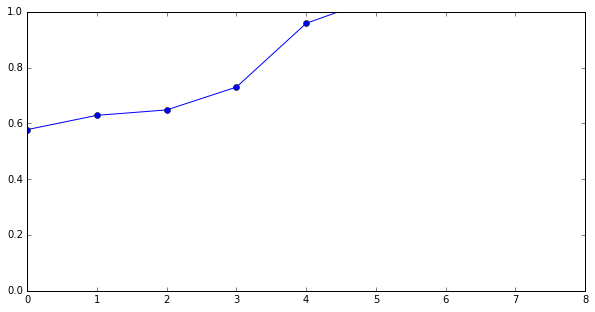

In [15]:
plt.figure(figsize=(10,5))
plt.axis([0,len(errors_sparsity)-1,0.0,1.0])
plt.plot(errors_sparsity,'ko-', color='blue', linewidth=1.0)
plt.show()

In [ ]:
# plt.figure(figsize=(20,10))
# plt.plot(person_errors,c='b')
# plt.plot(person_errors_sparse,c='g')
# plt.show()

# print min(person_errors),min(person_errors_sparse)

In [ ]:
std_scale = preprocessing.StandardScaler().fit(errors)
scaled_errors_train = std_scale.transform(errors)
# std_scale = preprocessing.StandardScaler().fit(errors_test)
# scaled_errors = std_scale.transform(errors_test)

In [ ]:
plt.figure()
plt.plot(scaled_errors_train)
plt.show()

In [ ]:
plt.figure()
plt.plot(e)
plt.show()